# uvlf-hod: Complete Tutorial

This notebook provides a comprehensive introduction to the `uvlf-hod` package using the unified model architecture.

**What you'll learn:**
1. Creating a unified `HODModel`
2. Computing UV luminosity functions
3. Calculating galaxy bias
4. Exploring UV-halo mass relations
5. Working with occupation distributions
6. Parameter exploration and updates
7. Comparing to observations

## Setup

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from uvlf_hod import HODModel, UVHMRModel

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.dpi'] = 100
%matplotlib inline

print("Imports successful!")

Imports successful!


## Part 1: Creating Your First Model

The `HODModel` is a unified class that combines:
- **UV-Halo Mass Relation (UVHMR)**: Connects halo mass to UV luminosity
- **Halo Occupation Distribution (HOD)**: Models galaxy populations in halos

In [48]:
# Create a complete model with all parameters
# Using best-fit values from Shuntov et al. (in prep) at z~5.4
model = HODModel(
    z=5.4,           # Redshift
    eps0=0.19,       # Star formation efficiency
    Mc=10**11.64,    # Characteristic halo mass [M_sun]
    a=0.69,          # Low-mass slope (beta)
    b=0.65,          # High-mass slope (gamma)
    sigma_UV=0.69,   # UV magnitude scatter [mag]
    Mcut=10**9.57,   # Satellite cutoff mass [M_sun]
    Msat=10**12.65,  # Satellite normalization [M_sun]
    asat=0.85,       # Satellite power-law slope
    add_dust=True    # Include dust attenuation
)

print(model)

HOD Model at z=5.4
UVHMR Parameters:
  eps0 = 0.190
  Mc = 4.37e+11 M_sun
  a = 0.69
  b = 0.65

HOD Parameters:
  sigma_UV = 0.69 mag
  Mcut = 3.72e+09 M_sun
  Msat = 4.47e+12 M_sun
  asat = 0.85

Settings:
  add_dust = True


## Part 2: UV Luminosity Function

The luminosity function Φ(M_UV) tells us the number density of galaxies as a function of UV magnitude.

In [37]:
# Define magnitude range
MUV = np.linspace(-24, -16, 25)

# Compute luminosity function
print("Computing luminosity function...")
phi = model.luminosity_function(MUV)

print(f"  Magnitude range: {MUV.min():.1f} to {MUV.max():.1f}")
print(f"  Φ range: {phi.min():.2e} to {phi.max():.2e} Mpc^-3 mag^-1")

Computing luminosity function...
  Magnitude range: -24.0 to -16.0
  Φ range: 1.07e-07 to 2.13e-02 Mpc^-3 mag^-1


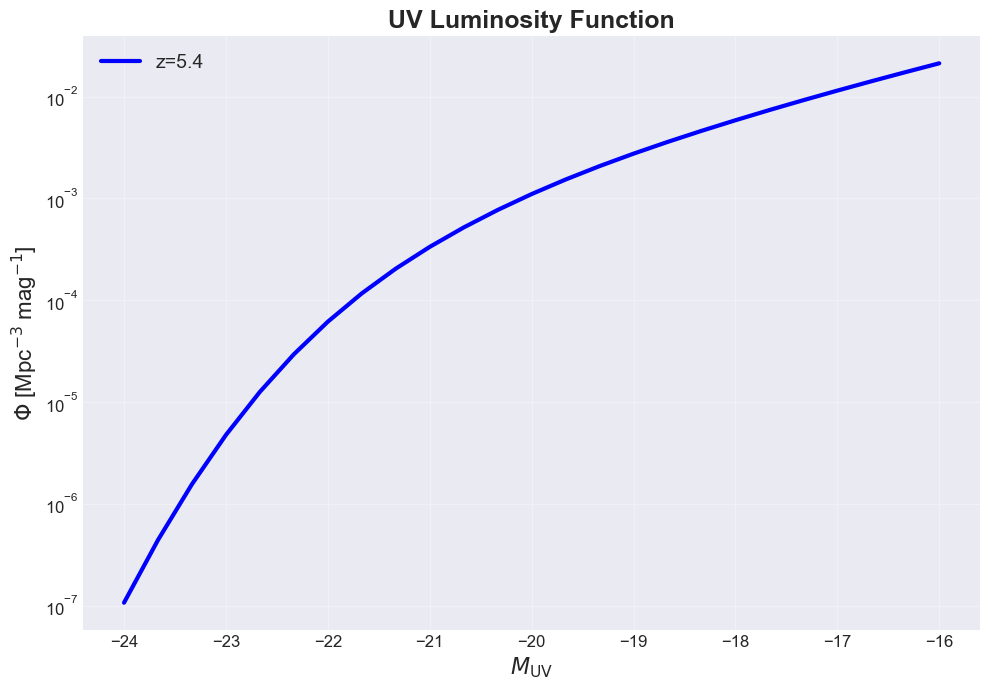

In [38]:
# Plot the luminosity function
fig, ax = plt.subplots(figsize=(10, 7))

ax.semilogy(MUV, phi, 'b-', linewidth=3, label=f'z={model.z}')
ax.set_xlabel(r'$M_{\rm UV}$', fontsize=16)
ax.set_ylabel(r'$\Phi$ [Mpc$^{-3}$ mag$^{-1}$]', fontsize=16)
ax.set_title('UV Luminosity Function', fontsize=18, fontweight='bold')
ax.legend(fontsize=14)
ax.grid(True, alpha=0.3)
ax.tick_params(labelsize=12)

plt.tight_layout()
plt.show()

## Part 3: Galaxy Bias

Galaxy bias b_g quantifies how strongly galaxies cluster compared to the underlying dark matter.

In [39]:
# Compute galaxy bias
print("Computing galaxy bias...")
bias = model.galaxy_bias(MUV)

print(f"  Bias range: {bias.min():.2f} to {bias.max():.2f}")

Computing galaxy bias...
  Bias range: 2.70 to 9.70


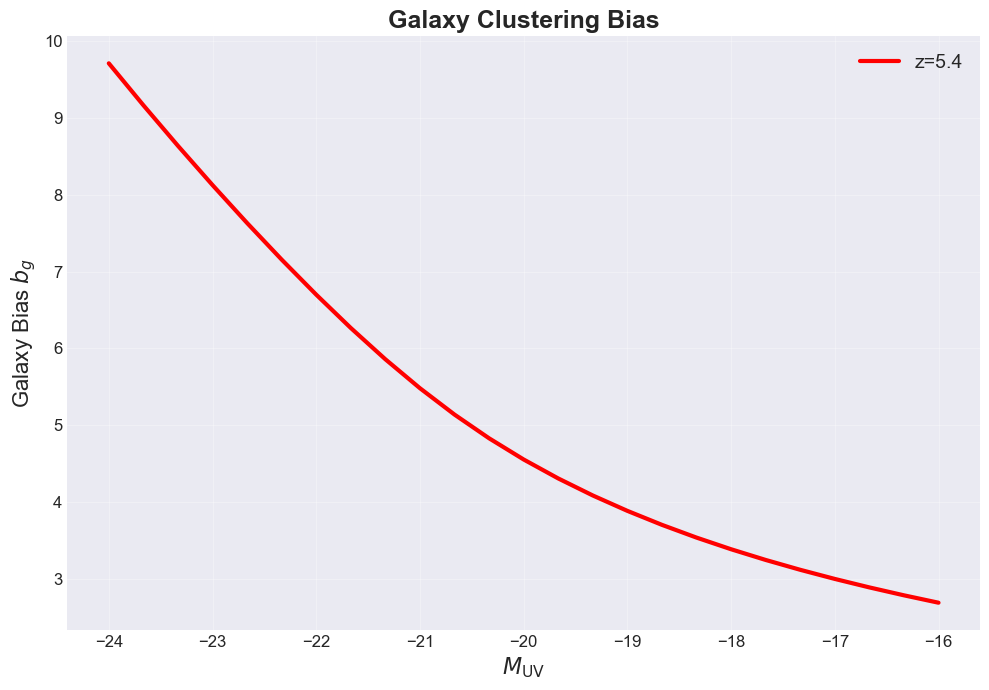

In [40]:
# Plot galaxy bias
fig, ax = plt.subplots(figsize=(10, 7))

ax.plot(MUV, bias, 'r-', linewidth=3, label=f'z={model.z}')
ax.set_xlabel(r'$M_{\rm UV}$', fontsize=16)
ax.set_ylabel('Galaxy Bias $b_g$', fontsize=16)
ax.set_title('Galaxy Clustering Bias', fontsize=18, fontweight='bold')
ax.legend(fontsize=14)
ax.grid(True, alpha=0.3)
ax.tick_params(labelsize=12)

plt.tight_layout()
plt.show()

## Part 4: UV-Halo Mass Relation

The `HODModel` inherits all UVHMR methods from the base class.

In [41]:
# Explore UVHMR for a single halo
Mh_example = 1e11  # M_sun

sfr = model.sfr(Mh_example)
MUV_example = model.MUV(Mh_example)
epsilon = model.star_formation_efficiency(Mh_example)

print(f"Halo mass: {Mh_example:.2e} M_sun")
print(f"  SFR: {sfr} M_sun/yr")
print(f"  M_UV: {MUV_example}")
print(f"  SFE: {epsilon}")

# Inverse
Mh_recovered = model.Mhalo(MUV_example)
print(f"\nInverse check:")
print(f"  M_UV = {MUV_example} → M_h = {Mh_recovered} M_sun")

Halo mass: 1.00e+11 M_sun
  SFR: [4.34936672] M_sun/yr
  M_UV: [-19.21614823]
  SFE: [0.12070767]

Inverse check:
  M_UV = [-19.21614823] → M_h = [1.04170543e+11] M_sun


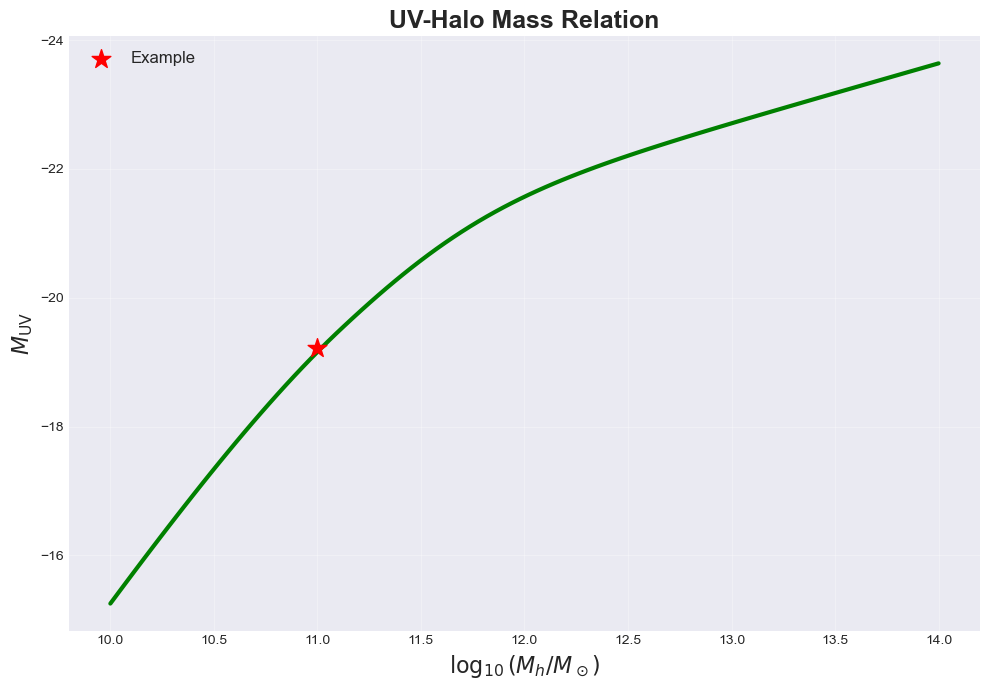

In [42]:
# Plot UVHMR
Mh_array = np.logspace(10, 14, 100)
MUV_array = model.MUV(Mh_array)

fig, ax = plt.subplots(figsize=(10, 7))

ax.plot(np.log10(Mh_array), MUV_array, 'g-', linewidth=3)
ax.scatter(np.log10(Mh_example), MUV_example, s=200, c='red', 
           marker='*', zorder=5, label=f'Example')

ax.set_xlabel(r'$\log_{10}(M_h / M_\odot)$', fontsize=16)
ax.set_ylabel(r'$M_{\rm UV}$', fontsize=16)
ax.set_title('UV-Halo Mass Relation', fontsize=18, fontweight='bold')
ax.invert_yaxis()
ax.legend(fontsize=12)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Part 5: Halo Occupation Distribution

In [43]:
MUV_thresh = -18
Mh_range = np.logspace(10, 14, 100)

N_cen = model.Ncen(Mh_range, MUV_thresh)
N_sat = model.Nsat(Mh_range, MUV_thresh)
N_tot = model.Ngal(Mh_range, MUV_thresh)

print(f"For M_UV < {MUV_thresh}:")
print(f"  Peak N_cen: {N_cen.max():.3f}")
print(f"  Max N_sat: {N_sat.max():.2f}")

For M_UV < -18:
  Peak N_cen: 1.000
  Max N_sat: 14.04


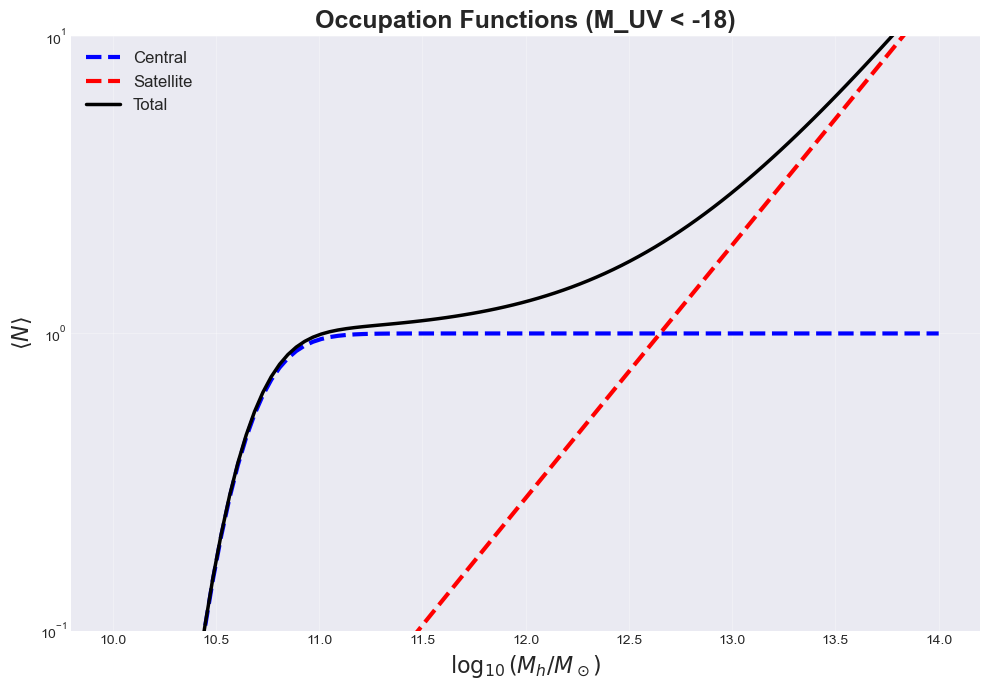

In [44]:
fig, ax = plt.subplots(figsize=(10, 7))

ax.plot(np.log10(Mh_range), N_cen, 'b--', linewidth=3, label='Central')
ax.plot(np.log10(Mh_range), N_sat, 'r--', linewidth=3, label='Satellite')
ax.plot(np.log10(Mh_range), N_tot, 'k-', linewidth=2.5, label='Total')

ax.set_ylim(0.1,10)
ax.set_yscale('log')
ax.set_xlabel(r'$\log_{10}(M_h / M_\odot)$', fontsize=16)
ax.set_ylabel(r'$\langle N \rangle$', fontsize=16)
ax.set_title(f'Occupation Functions (M_UV < {MUV_thresh})', fontsize=18, fontweight='bold')
ax.legend(fontsize=12)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Part 6: Mean Properties

In [45]:
thresholds = [-21, -20, -19, -18, -17]

print("Mean Properties by Brightness Threshold:")
print("="*60)

for thresh in thresholds:
    mean_mass = model.mean_halo_mass(thresh)
    mean_b = model.mean_bias(thresh)
    
    print(f"\nM_UV < {thresh}:")
    print(f"  Mean halo mass: {10**mean_mass:.2e} M_sun")
    print(f"  Mean bias: {mean_b:.2f}")

Mean Properties by Brightness Threshold:

M_UV < -21:
  Mean halo mass: 4.74e+11 M_sun
  Mean bias: 6.08

M_UV < -20:
  Mean halo mass: 2.67e+11 M_sun
  Mean bias: 5.17

M_UV < -19:
  Mean halo mass: 1.56e+11 M_sun
  Mean bias: 4.48

M_UV < -18:
  Mean halo mass: 9.53e+10 M_sun
  Mean bias: 3.95

M_UV < -17:
  Mean halo mass: 5.99e+10 M_sun
  Mean bias: 3.52


## Part 7: Parameter Exploration

TypeError: HODModel.__init__() missing 8 required positional arguments: 'z', 'Mc', 'a', 'b', 'sigma_UV', 'Mcut', 'Msat', and 'asat'

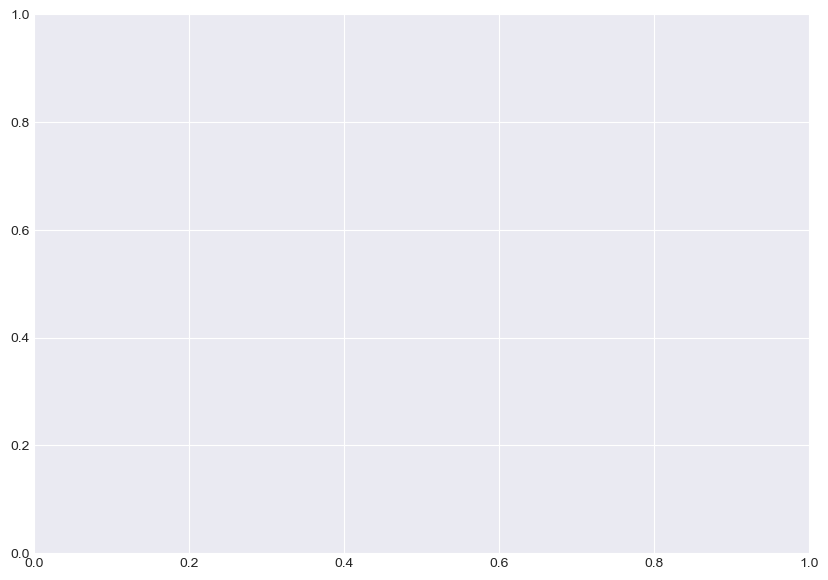

In [49]:
eps0_values = [0.1, 0.25, 0.5, 0.75, 1.0]
colors = plt.cm.viridis(np.linspace(0, 1, len(eps0_values)))

fig, ax = plt.subplots(figsize=(10, 7))

for eps0, color in zip(eps0_values, colors):
    model_var = HODModel(eps0=eps0)
    phi_var = model_var.luminosity_function(MUV)
    ax.semilogy(MUV, phi_var, linewidth=3, color=color,
                label=f'$\epsilon_0={eps0}$')

ax.set_xlabel(r'$M_{\rm UV}$', fontsize=16)
ax.set_ylabel(r'$\Phi$ [Mpc$^{-3}$ mag$^{-1}$]', fontsize=16)
ax.set_title('Effect of Star Formation Efficiency', fontsize=18, fontweight='bold')
ax.legend(fontsize=12)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Part 8: Comparison to Observations

Compare model predictions to Bouwens+2021 data.

In [32]:
# Load observational data
from bouwens21_data import bouwens21, redshift_centers

print("Loaded Bouwens+2021 data:")
for key in bouwens21.keys():
    print(f"  {key}: z={redshift_centers[key]}, {len(bouwens21[key]['M_AB'])} points")

Loaded Bouwens+2021 data:
  z4: z=4.3, 12 points
  z5: z=5.4, 12 points
  z6: z=6.0, 10 points
  z7: z=7.3, 10 points
  z8: z=8.0, 7 points


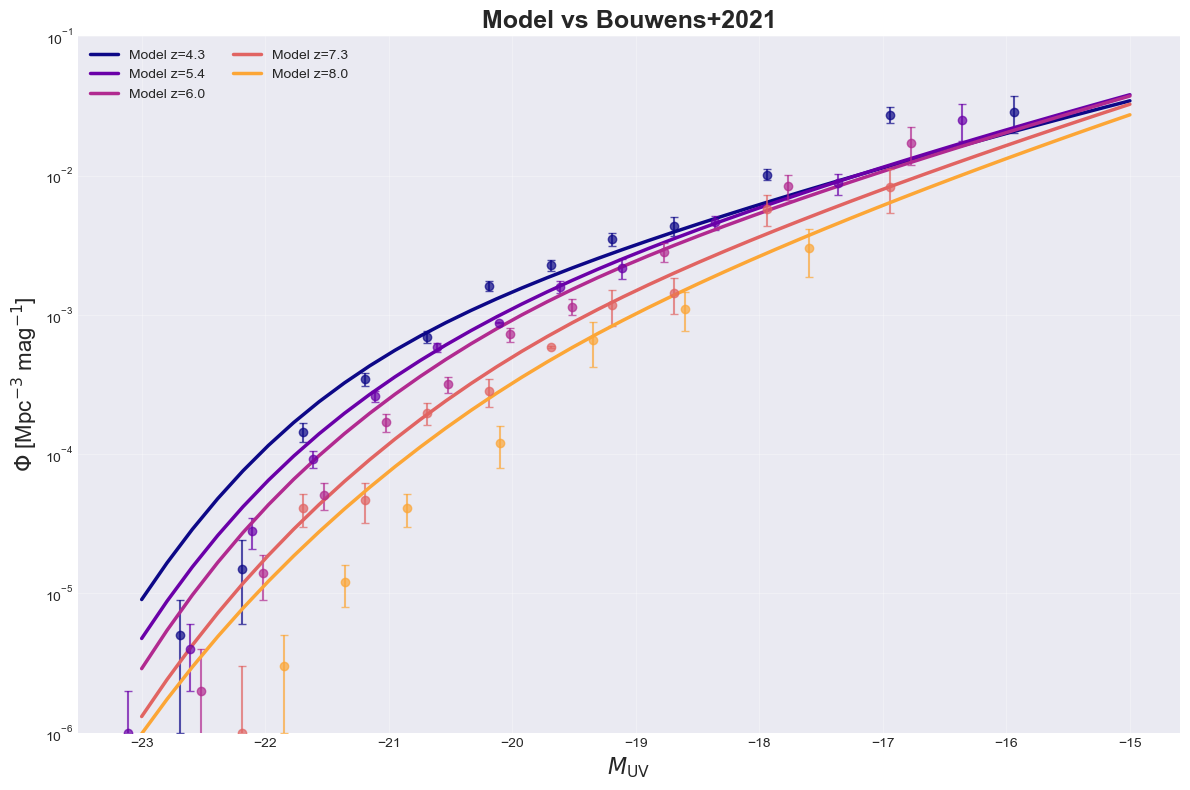

In [33]:
# Multi-redshift comparison
redshift_bins = ['z4', 'z5', 'z6', 'z7', 'z8']
colors = plt.cm.plasma(np.linspace(0, 0.8, len(redshift_bins)))

fig, ax = plt.subplots(figsize=(12, 8))

for zbin, color in zip(redshift_bins, colors):
    z_val = redshift_centers[zbin]
    model.update_parameters(z=z_val)
    
    MUV_model = np.linspace(-23, -15, 40)
    phi_model = model.luminosity_function(MUV_model)
    
    ax.semilogy(MUV_model, phi_model, '-', linewidth=2.5, color=color, 
                label=f'Model z={z_val}')
    
    obs = bouwens21[zbin]
    ax.errorbar(obs['M_AB'], obs['Fi_k'], yerr=obs['Fi_k_error'],
                fmt='o', color=color, markersize=6, capsize=3, alpha=0.7)

ax.set_xlabel(r'$M_{\rm UV}$', fontsize=16)
ax.set_ylabel(r'$\Phi$ [Mpc$^{-3}$ mag$^{-1}$]', fontsize=16)
ax.set_title('Model vs Bouwens+2021', fontsize=18, fontweight='bold')
ax.set_ylim(1e-6, 1e-1)
ax.legend(fontsize=10, ncol=2)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

model.update_parameters(z=6.0)